# Welcome to Bank Dataset Analysis!

### Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch

In [2]:
df = pd.read_csv("train.csv")
df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [3]:
df.isnull().sum() # no need to implement missing value imputation

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### Feature Engineering

In [4]:
for index in df.columns:
    print(f"{index}: {df[index].dtype}\n   {df[index].nunique()} unique values")

id: int64
   750000 unique values
age: int64
   78 unique values
job: object
   12 unique values
marital: object
   3 unique values
education: object
   4 unique values
default: object
   2 unique values
balance: int64
   8217 unique values
housing: object
   2 unique values
loan: object
   2 unique values
contact: object
   3 unique values
day: int64
   31 unique values
month: object
   12 unique values
duration: int64
   1760 unique values
campaign: int64
   52 unique values
pdays: int64
   596 unique values
previous: int64
   50 unique values
poutcome: object
   4 unique values
y: int64
   2 unique values


Dataset Content:
The dataset contains 45,211 entries with 17 attributes. The attributes represent client information and campaign details, and they include both categorical and numerical data.

age: Age of the client (numeric)

job: Type of job (categorical: "admin.", "blue-collar", "entrepreneur", etc.)

marital: Marital status (categorical: "married", "single", "divorced")

education: Level of education (categorical: "primary", "secondary", "tertiary", "unknown")

default: Has credit in default? (categorical: "yes", "no")

balance: Average yearly balance in euros (numeric)

housing: Has a housing loan? (categorical: "yes", "no")

loan: Has a personal loan? (categorical: "yes", "no")

contact: Type of communication contact (categorical: "unknown", "telephone", "cellular")

day: Last contact day of the month (numeric, 1-31)

month: Last contact month of the year (categorical: "jan", "feb", "mar", …, "dec")

duration: Last contact duration in seconds (numeric)

campaign: Number of contacts performed during this campaign (numeric)

pdays: Number of days since the client was last contacted from a previous campaign (numeric; -1 means the client was not previously contacted)

previous: Number of contacts performed before this campaign (numeric)

poutcome: Outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")

y: The target variable, whether the client subscribed to a term deposit (binary: "yes", "no")

In [5]:
def merge_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = dataframe.copy()

    # life status
    dataframe["socioeconomic_status"] = dataframe["job"] + " " + dataframe["education"]
    dataframe["age_group"] = pd.cut(dataframe["age"],
                                    bins=[0, 25, 45, 65, 100],
                                    labels=["young", "adult", "middle-age", "senior"])
    dataframe["age_marital"] = dataframe["age_group"].astype(str) + " " + dataframe["marital"]
    # dataframe["status"] = dataframe["job"] + " " + dataframe["marital"]

    # contact-related information
    dataframe["last_contact_info"] = dataframe["contact"] + " " + dataframe["day"].astype(str) + " " + dataframe["month"]
    dataframe["previously_contacted"] = (dataframe["pdays"] != -1).astype(int)
    dataframe["previous_contact_outcome"] = dataframe["previous"].astype(str) + " " + dataframe["poutcome"]
    # dataframe["total_contacts"] = dataframe["campaign"] + dataframe["previous"]

    # credit and loan information
    # dataframe["credit_info"] = dataframe["default"] + " " + dataframe["housing"] + " " + dataframe["loan"]

    dataframe.drop(columns="age_group", inplace=True)
    
    return dataframe

df = merge_columns(df)

In [6]:
# Create a new column 'education_unknown'
df['education_unknown'] = (df['education'] == 'unknown').astype(int)

# Define the mapping for ordinal encoding
education_map = {'primary': 1, 'secondary': 2, 'tertiary': 3, "unknown": np.nan}

# Apply the mapping to the 'education' column
# 'unknown' values will become NaN because they are not in the map
df['education'] = df['education'].map(education_map)

df.isnull().sum()

id                              0
age                             0
job                             0
marital                         0
education                   21299
default                         0
balance                         0
housing                         0
loan                            0
contact                         0
day                             0
month                           0
duration                        0
campaign                        0
pdays                           0
previous                        0
poutcome                        0
y                               0
socioeconomic_status            0
age_marital                     0
last_contact_info               0
previously_contacted            0
previous_contact_outcome        0
education_unknown               0
dtype: int64

In [7]:
df['pdays_contacted'] = (df['pdays'] > -1).astype(int)
df['pdays_contacted'].describe()

count    750000.000000
mean          0.103421
std           0.304509
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: pdays_contacted, dtype: float64

<Axes: >

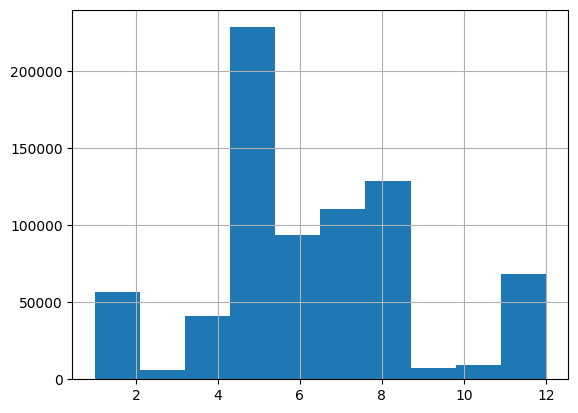

In [8]:
df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                               'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
df['month'].hist()

In [9]:
# encoding: basically one-hot encoding on df
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'poutcome'], drop_first=True)
df

,id,age,education,default,balance,housing,loan,day,month,duration,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0,42,2.0,no,7,no,no,25,8,117,...,True,False,False,True,False,False,False,False,False,True
1,1,38,2.0,no,514,no,no,18,6,185,...,False,False,False,True,False,False,True,False,False,True
2,2,36,2.0,no,602,yes,no,14,5,111,...,False,False,False,True,False,False,True,False,False,True
3,3,27,2.0,no,34,yes,no,28,5,10,...,False,False,False,False,True,False,True,False,False,True
4,4,26,2.0,no,889,yes,no,3,2,902,...,True,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,2.0,no,1282,no,yes,4,7,1006,...,False,False,False,False,True,False,True,False,False,True
749996,749996,69,3.0,no,631,no,no,19,8,87,...,False,False,False,False,False,False,False,False,False,True
749997,749997,50,2.0,no,217,yes,no,17,4,113,...,False,False,False,True,False,False,False,False,False,True
749998,749998,32,2.0,no,-274,no,no,26,8,108,...,True,False,False,True,False,False,False,False,False,True


In [10]:
df.isnull().sum()

id                              0
age                             0
education                   21299
default                         0
balance                         0
housing                         0
loan                            0
day                             0
month                           0
duration                        0
campaign                        0
pdays                           0
previous                        0
y                               0
socioeconomic_status            0
age_marital                     0
last_contact_info               0
previously_contacted            0
previous_contact_outcome        0
education_unknown               0
pdays_contacted                 0
job_blue-collar                 0
job_entrepreneur                0
job_housemaid                   0
job_management                  0
job_retired                     0
job_self-employed               0
job_services                    0
job_student                     0
job_technician

In [11]:
# Convert binary categorical variables to numeric before imputation
for col in ['default', 'housing', 'loan']:
	if col in df.columns:
		df[col] = df[col].map({'yes': 1, 'no': 0})

df

,id,age,education,default,balance,housing,loan,day,month,duration,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0,42,2.0,0,7,0,0,25,8,117,...,True,False,False,True,False,False,False,False,False,True
1,1,38,2.0,0,514,0,0,18,6,185,...,False,False,False,True,False,False,True,False,False,True
2,2,36,2.0,0,602,1,0,14,5,111,...,False,False,False,True,False,False,True,False,False,True
3,3,27,2.0,0,34,1,0,28,5,10,...,False,False,False,False,True,False,True,False,False,True
4,4,26,2.0,0,889,1,0,3,2,902,...,True,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,2.0,0,1282,0,1,4,7,1006,...,False,False,False,False,True,False,True,False,False,True
749996,749996,69,3.0,0,631,0,0,19,8,87,...,False,False,False,False,False,False,False,False,False,True
749997,749997,50,2.0,0,217,1,0,17,4,113,...,False,False,False,True,False,False,False,False,False,True
749998,749998,32,2.0,0,-274,0,0,26,8,108,...,True,False,False,True,False,False,False,False,False,True


In [12]:
df = df.sample(n=50000, random_state=3407).reset_index(drop=True)
df_X, df_y = df.drop(columns=['y']), df['y']

In [13]:
from sklearn.impute import KNNImputer
# This is very dangerous since it might kill the terminal
# imputer = KNNImputer(n_neighbors=1)
# # impute the missing values
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
# Therefore we might adopt dimensional reduction first and then conduct imputation
from sklearn.decomposition import PCA

column = "education"
n_components = 5
neighbors = 7
df1 = df_X.copy()
df2 = df_X.copy()
df2 = df2.drop(columns=[column])
df1 = df1[column]
pca = PCA(n_components=n_components)
df2_numeric = df2.select_dtypes(include=np.number)
df2_reduced = pca.fit_transform(df2_numeric)
df_reduced = pd.concat([pd.DataFrame(df2_reduced, columns=[f'PC{i+1}' for i in range(df2_reduced.shape[1])]), df1], axis=1)

imputer1 = KNNImputer(n_neighbors=neighbors)
df_reduced_1 = imputer1.fit_transform(df_reduced)
# clip to the set {1, 2, 3}
df_reduced_1 = np.clip(df_reduced_1, 1, 3)
# Select the imputed 'education' column (the last column)
imputed_education_values = df_reduced_1[:, n_components].astype(int)
# Create a new DataFrame for the imputed values, preserving the original index from df_X
df_reduced_education = pd.DataFrame(imputed_education_values, columns=['education'], index=df_X.index)
df_X['education'] = df_reduced_education['education']
df_reduced_education.isnull().sum(), df_X['education'].isnull().sum()  # Check if there are any null values left

(education    0
 dtype: int64,
 np.int64(0))

In [14]:
df_X['education'].describe()

count    50000.000000
mean         2.163960
std          0.644116
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: education, dtype: float64

### Modeling

#### Logistic Regression (C=0.01)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

oe = OneHotEncoder()
df_X1=oe.fit_transform(df_X)

sc = StandardScaler(with_mean=False)
df_X1 = sc.fit_transform(df_X1)

X_train, X_test, y_train, y_test = train_test_split(df_X1, df_y, test_size=0.2, random_state=42)

for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=C, max_iter=10000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    print(f"C: {C}, AUC: {auc}; Train_AUC: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}")

C: 0.001, AUC: 0.9282971321883895; Train_AUC: 1.0
C: 0.01, AUC: 0.9300103254828971; Train_AUC: 1.0
C: 0.1, AUC: 0.9301121219911054; Train_AUC: 1.0
C: 1, AUC: 0.9215982928687447; Train_AUC: 1.0
C: 10, AUC: 0.9204077121720886; Train_AUC: 1.0
C: 100, AUC: 0.9204039948838676; Train_AUC: 1.0


#### AdaBoost (lr=1.46)

In [21]:
from sklearn.ensemble import AdaBoostClassifier

for lr in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = AdaBoostClassifier(learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    print(f"Learning Rate: {lr}, AUC: {auc}")

Learning Rate: 0.001, AUC: 0.5738404038538176
Learning Rate: 0.01, AUC: 0.5738404038538176
Learning Rate: 0.1, AUC: 0.7007879411932629
Learning Rate: 1, AUC: 0.7589999598723502
Learning Rate: 10, AUC: 0.5738404038538176
Learning Rate: 100, AUC: 0.4261595961461825


/home/codespace/.local/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:609: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:1363: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)


In [22]:
Xs = np.linspace(0.1, 2, 50)
AUCs = []
for lr in Xs:
    model = AdaBoostClassifier(learning_rate=lr, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    AUCs.append(auc)
print(Xs[np.argmax(AUCs)], np.max(AUCs))
plt.plot(Xs, AUCs)
plt.xlabel('Learning Rate')
plt.ylabel('AUC')
plt.title('AUC vs Learning Rate')
plt.show()

KeyboardInterrupt: 

#### Random Forest (n_estimators=100)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

for n_estimators in [100, 200, 500, 1000]:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)


#### Gaussian Mixture Model (n_components=7)

In [ ]:
from sklearn.mixture import GaussianMixture

for n_components in [5,7,9,11,13]:
    model = GaussianMixture(n_components=n_components, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"n_components: {n_components}, AUC: {roc_auc_score(y_test, y_pred)}")

n_components: 5, AUC: 0.45516497658727967
n_components: 7, AUC: 0.4919549304538265


n_components: 9, AUC: 0.6009198000785205
n_components: 11, AUC: 0.5957916103473673
n_components: 13, AUC: 0.41063863106953347


#### XgBoost

In [23]:
import xgboost as xgb

xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

params = {
    'objective': 'binary:logistic',
    'max_depth': 10,
    'learning_rate': 1,
    'seed': 42
}
n=1000
model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n)

preds = model.predict(xgb_test)
preds = np.round(preds)
roc_auc_score(y_test,preds)

KeyboardInterrupt: 

In [25]:
gradient_booster = xgb.XGBClassifier(
    n_estimators=2700,
    learning_rate=3e-1,
    max_depth=5,
    subsample=0.93,
    colsample_bytree=0.76,
    device="cpu"
)

# train and fit by the model above
gradient_booster.fit(X_train, y_train)
y_pred = gradient_booster.predict_proba(X_test)[:, 1]
y_pred = np.round(y_pred)
roc_auc_score(y_test,y_pred), roc_auc_score(y_train, np.round(gradient_booster.predict_proba(X_train)[:, 1]))

(0.7673121975950289, 0.9216422506038826)

#### Stacking

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# averaging by three classifiers above

# model 1: Logistic Regression
Model_1 = LogisticRegression(C=0.01, max_iter=10000, random_state=42)
Model_1.fit(X_train, y_train)
Model_1_pred = Model_1.predict_proba(X_test)[:, 1]

# model 2: AdaBoost
Model_2 = AdaBoostClassifier(learning_rate=1.46, random_state=42)
Model_2.fit(X_train, y_train)
Model_2_pred = Model_2.predict_proba(X_test)[:, 1]

# model 3: RandomForest
Model_3 = RandomForestClassifier(n_estimators=100, random_state=42)
Model_3.fit(X_train, y_train)
Model_3_pred = Model_3.predict_proba(X_test)[:, 1]

# majority vote evaluation
best_auc = 0
best_weights = (0, 0, 0)

# Define a search space for the weights
# This will create 1000 (10*10*10) combinations
for a in np.linspace(0, 1, 20):
    for b in np.linspace(0, 1, 20):
        for c in np.linspace(0, 1, 20):
            # Skip if all weights are zero
            if a + b + c == 0:
                continue
            
            # Calculate the weighted average of predictions
            y_pred = (a * Model_1_pred + b * Model_2_pred + c * Model_3_pred) / (a + b + c)
            auc = roc_auc_score(y_test, y_pred)
            
            # Update the best weights if the current combination is better
            if auc >= best_auc:
                best_auc = auc
                best_weights = (a, b, c)

print(f"Best AUC: {best_auc}")
print(f"Best Weights (a, b, c): {best_weights}")

Best AUC: 0.955056174420501
Best Weights (a, b, c): (np.float64(0.0), np.float64(0.6842105263157894), np.float64(0.894736842105263))
